___

<p style = "font-family:courier;font-size:25px;">
BR35H-MASK-RCNN      
</p>

<p style = "font-family:courier;font-size:15px;">
Capstone Phase 5 Project     
</p>

<b>Name:</b> Ansel Vallejo

<i><font color = 'gray'>Source: </font></i>
<i>https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection</i>

___

#### <b> Overview </b>

<div style="text-align: justify">
In the medical field, Brain tumor is seen as a serious, abnormal growth of cells in or near the brain that can be either benign, which is non-cancerous or malignant, which is cancerous. There are many treatments an individual with such tumor can receive, such as radiation therapy, chemotherapy, therapeutic drug, etc. Brain tumor can be seen via Magnetic Resonance Imaging (MRI) scanned images. Human error is prone to occur in any industry, and because of such error in the medical field can cost a life. To detect and identify what constitutes a benign or malignant tumor without human intervention would be to build a robust deep learning model to help the medical practitioner properly classify a cancerous from noncancerous tumors using over 3000 MRI scan trained images and testing images to help better serve the model.
</div>

<b>Algorithm Implemented: </b> <i>Convolutional Neural Network</i> (Deep Learning) <br>
<b>Data type: </b> Unstructured <br>
<br>
<br>
<b>Data Classification: </b>
    <ul>
        <li><b>NO</b> (no tumor) - classified as 0</li>
        <li><b>YES</b> (yes tumor) - classified as 1</li>
    </ul>


___

### Import Libraries

In [1]:
import pandas as pd                       #Data Analysis and manipulation tool
import numpy as np                        #Scientific computing
import matplotlib.pyplot as plt           #Visualization
from matplotlib.colors import Normalize
import tensorflow as tf
import seaborn as sns
%matplotlib inline

#Import image data
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.regularizers import l2
from PIL import Image
import random
import pickle
import cv2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import os

#SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#KERAS
from keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

                                                Number of GPUs Available

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

___

### Functions 
<i>(Tools)</i>

In [3]:
def model_acc_loss(test, loss):
    print('Model Accuracy (Test data)')
    print('________________________________________')
    print('')
    print('Model Accuracy:      ', test)
    print('Test Loss:          ', loss)
    print('________________________________________')
    print('')

    return

In [4]:
def plot_training_results(results):
    # Extract loss and accuracy values from the training results
    train_loss = results.history['loss']
    train_acc = results.history['accuracy']
    val_loss = results.history['val_loss']
    val_acc = results.history['val_accuracy']
    
    # Create subplots for loss and accuracy plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot loss values
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    
    # Plot accuracy values
    sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
    sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    
    # Display the plots
    plt.tight_layout()
    plt.show()
    
    # Updated function in 01_brain_tumor_classification_hyperparameter_tuning
    ###
    
    # Use the trained model to predict probabilities for the test data
    y_pred_prob = model.predict(X_val)

    # Convert probabilities to class labels based on a threshold
    threshold = 0.5
    y_pred = (y_pred_prob > threshold).astype(int)
    # print(y_pred)

    # Print the classification report
    print(classification_report(y_val, y_pred, zero_division=1))
    
    
    model.summary()

In [52]:
def split_train_val_data(image, label, test_size, random_state):
    
    """
    Split the data into training and validation sets.

    Parameters:
    - image: Input data (images)
    - label: Target labels
    - test_size: Percentage of data to allocate for validation
    - random_state: Random seed for reproducibility

    Returns:
    - X_train: Training data (images)
    - X_val: Validation data (images)
    - y_train: Training labels
    - y_val: Validation labels
    """
    
    X_train, X_val, y_train, y_val = train_test_split(image, label, test_size=test_size, random_state=random_state)
    
    return X_train, X_val, y_train, y_val

___

### Import Data

<b> load_data </b> <i>(Function)</i>


<div style="text-align: justify">
The function is iterating through the <i>directory</i>, and <i>categories</i> defined, then classifying the data by 'yes' <b>{1}</b> or 'no' <b>{0}</b>, depending on the data folder the images are extracted from. After categorizing the data, we proceed in converting the images into grayscale, and resizing according to spec. we then append the <i>data</i> list to combine both the resized array with its respective categorical number. After the data is prepared, the data is shuffled then separated into the <i> image</i> and <i>label</i> list, followed up by reshaping the <i>image</i> variable list. Then, the data is returned and included into the <i> image </i> and <i>label</i> variables outside of the function to then be referenced and follow up with saving into a pickle file format to then be referenced when needed.
    </div>

In [5]:
data = []                    # Empty list to store images and labels

directory = "data/"          # Folder path
categories = ["no", "yes"]   # Folder
IMG_SIZE = 128               # Image size

# Function that loads the image data, categorizes images, resize, shuffles, and creates image and label lists.
def load_data():
    
    for classification in categories:
        
        # Defining file path and category numnber.
        path = os.path.join(directory, classification)
        cat_num = categories.index(classification)
        
        for img in os.listdir(path):
            try:
                
        # Iterating and changing the size, color, and adding both categories and images into the data list.
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, cat_num])
            except Exception as e:
                pass
       
    random.shuffle(data)              # Shuffles data so that its not concatenated and sorted by category.


    image = []                        # List for image arrays.
    label = []                        # List for label arrays.
    
    
    # For loop that iterates over the data list, and separates the image from the labels after the above.
    for images, labels in data:
        image.append(images)          
        label.append(labels)
        
    image = np.array(image)           # Convert the image list into n numpy array.
    label = np.array(label)           # Convert the label list into a numpy array.
    
    
    return image, label, img_array


image, label, img_array= load_data()  # Assign value to the image, label, and img_array variables from load_data().


___

### Saving Data

 <b> Save Data</b> <i>(.pkl file extension)</i><br>


<div style="text-align: justify">
This code saves two objects, image and label, into separate pickle files named "image.pickle" and "label.pickle", respectively. The pickle module is used to serialize the objects, converting them into a byte stream that can be stored in a file. Later, these objects can be loaded and deserialized using the pickle module to retrieve their original state.
    </div>

In [5]:
# Creates and writes the '.pickle' file in write format, saves then closes file
pickle_out = open('image.pickle', 'wb')
pickle.dump(image, pickle_out)
pickle_out.close()
    
pickle_out = open('label.pickle', 'wb')
pickle.dump(label, pickle_out)
pickle_out.close()

In [6]:
# Opens and loads the '.pickle' file in readable format
pickle_in = open('image.pickle', 'rb')
image = pickle.load(pickle_in)

pickle_in = open('label.pickle', 'rb')
label = pickle.load(pickle_in)

___

###### <i> <font color = 'blue'> TESTING pickle_in </font> </i>

This is a test code to see if the image variable arrays were properly saved in pickle file format.  <br>
And as you can see, the array is 3x3, meaning that the color channel is RGB.

In [8]:
image[1]

array([[[38, 37, 33],
        [38, 37, 33],
        [38, 37, 33],
        ...,
        [43, 42, 38],
        [41, 40, 36],
        [ 9,  8,  4]],

       [[38, 37, 33],
        [38, 37, 33],
        [38, 37, 33],
        ...,
        [43, 42, 38],
        [40, 38, 35],
        [ 7,  6,  3]],

       [[36, 35, 31],
        [36, 35, 31],
        [36, 35, 31],
        ...,
        [41, 40, 36],
        [39, 39, 35],
        [ 8,  7,  3]],

       ...,

       [[40, 39, 35],
        [40, 39, 35],
        [40, 39, 35],
        ...,
        [42, 41, 37],
        [39, 39, 35],
        [ 8,  7,  3]],

       [[40, 39, 35],
        [40, 39, 35],
        [40, 39, 35],
        ...,
        [42, 41, 37],
        [40, 39, 35],
        [ 8,  7,  3]],

       [[40, 39, 35],
        [40, 39, 35],
        [40, 39, 35],
        ...,
        [42, 41, 37],
        [40, 38, 35],
        [ 8,  7,  3]]], dtype=uint8)

___

### Plot Multiple Images by Category

<b> plot_images_5_5</b> <i>(Function)</i><br>

<div style="text-align: justify">
The function creates a 5x5 grid of subplots using the subplots() function. It then loops through each subplot and resizes the corresponding image using the resize() function from OpenCV. It then displays the image in the subplot using the imshow() function from matplotlib. The title of each subplot is set to the corresponding category label using the set_title() function from matplotlib. The x and y ticks are removed from each subplot using the set_xticks() and set_yticks() functions from matplotlib.
    </div>

In [9]:
def plot_images_5_5():
    # Create a figure with 5 rows and 5 columns of subplots
    fig, axs = plt.subplots(5, 5)

    # Iterate over the rows
    for i in range(len(axs)):
        # Iterate over the columns
        for j in range(len(axs[i])):
            # Resize the image to a specified size
            new_array = cv2.resize(image[i*len(axs[i])+j], (IMG_SIZE, IMG_SIZE))
            
            # Display the image in the current subplot
            axs[i][j].imshow(new_array, cmap='gray')
            
            # Set the title of the subplot to the corresponding label/category
            axs[i][j].set_title(categories[label[i*len(axs[i])+j]])
            
            # Remove the x-axis ticks
            axs[i][j].set_xticks([])
            
            # Remove the y-axis ticks
            axs[i][j].set_yticks([])

    # Adjust the spacing between subplots to prevent overlapping
    plt.tight_layout()
    
    # Display the plot
    plt.show()

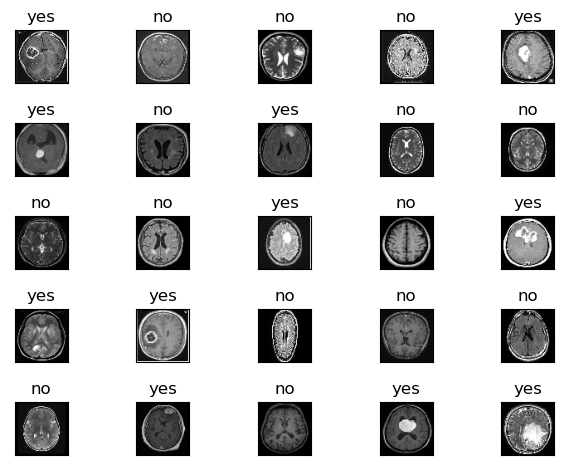

In [10]:
plot_images_5_5()

___

<b>plot_images_2_3</b> <i>(Function)</i>

<div style="text-align: justify">
The function loops through the first 6 images in the image list and creates a 2x3 grid of subplots using the subplot() function. It then displays the corresponding image in each subplot using the imshow() function from matplotlib. The title of each subplot is set to the corresponding category label using the title() function from matplotlib. The x and y ticks are removed from each subplot using the xticks() and yticks() functions from matplotlib.
    </div>

In [40]:
def plot_images_2_3():
    # Iterate over the range 0-5 (6 iterations)
    for i in range(6):
        # Create a subplot grid of 2 rows and 3 columns and select the i+1-th subplot
        plt.subplot(2, 3, i+1)
        
        # Display the image in the current subplot
        plt.imshow(image[i])
        
        # Set the title of the subplot to the corresponding label/category
        plt.title(categories[label[i]])
        
        # Remove the x-axis ticks
        plt.xticks([])
        
        # Remove the y-axis ticks
        plt.yticks([])

    # Display the plot
    plt.show()


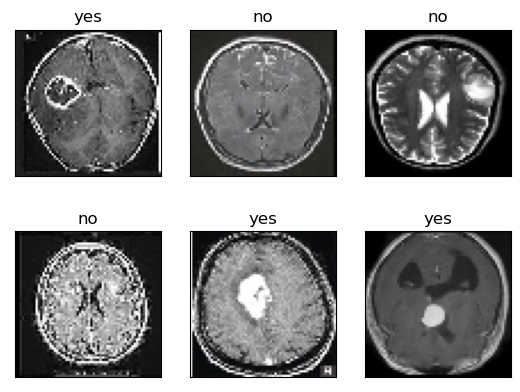

In [12]:
plot_images_2_3()

___

### <font size = '4'> <b> DISPLAY IMAGE BY IMAGE SIZE </b></font>

<div style="text-align: justify">
The code plots runs a for-loop displaying 3 images side by side comparing the different image size.
As it iterates through the loop, the IMG_SIZE will increase by 20, thus plotting images in sizes of 40, 60, 80.
<br>
<br>
A 3x3 version variant is made for visualizing better image classification. The code follows similar concepts but its tailored for its size, making it slighly unique.
    </div>

<b><i> <font color = 'purple'> (1 x 3) </font> </i></b>

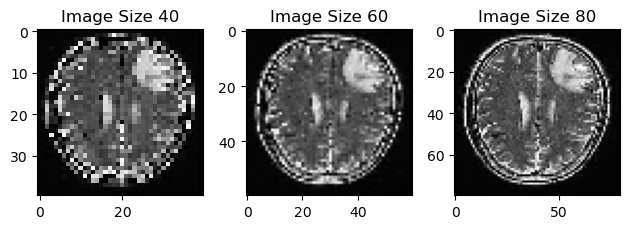

In [13]:
# Figure with 1 row and 3 columns for subplots
fig, axs = plt.subplots(1, 3)

# Directory path where the images are stored
directory = "data/"

# Categories or folders containing the images
categories = ["no", "yes"]

# Initial image size
IMG_SIZE = 40

# Loop through the subplots
for i in range(len(axs)):
    # Resize the image to the specified size
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    
    # Display the resized image in the current subplot as grayscale
    axs[i].imshow(new_array, cmap='gray')
    
    # Set the title for the current subplot
    axs[i].set_title(f'Image Size {IMG_SIZE}')
    
    # Increase the image size by 20 for the next iteration
    IMG_SIZE += 20

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


<b><i> <font color = 'purple'> (3 x 3) </font> </i></b>

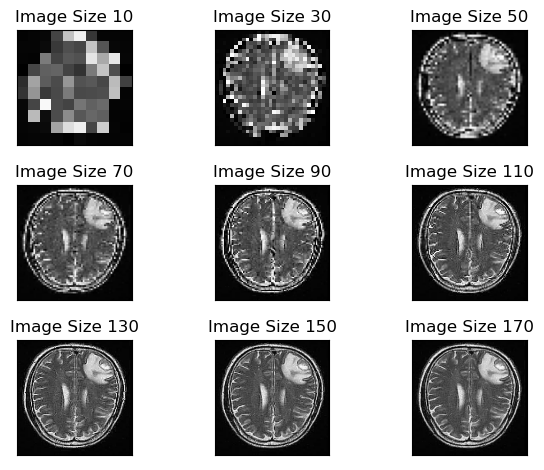

In [14]:
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3)

# Initial image size
IMG_SIZE = 10

# Loop through the rows of subplots
for i in range(len(axs)):
    # Loop through the columns of subplots
    for j in range(len(axs)):
        # Resize the image to the specified size
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        
        # Display the resized image in the current subplot as grayscale
        axs[i, j].imshow(new_array, cmap='gray')
        
        # Set the title for the current subplot
        axs[i, j].set_title(f'Image Size {IMG_SIZE}')
        
        # Increase the image size by 20 for the next iteration
        IMG_SIZE += 20

# Remove x-axis and y-axis ticks for all subplots
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

___

___

### Train Test Split

<div style="text-align: justify">
A Train Test Split is conducted by splitting the image array (containing the image) and the label array (containing the respective labels for the images) into training and validation data, with a 20% split, and random state of 42 to ensure the code will be ran the same way for consistency.
    </div>

In [54]:
#  Train Test Split function 
#  (can be found above in the "Functions (Tools) dropdown")

X_train, X_val, y_train, y_val = split_train_val_data(image, # Input
                                                        label, # Target
                                                        0.20,  # Percentage data allocation to validation
                                                        42)    # fixed random seed for reuseability             

<i><b><font color= 'red'> Train / Validation Size Check </font></b></i><br>
To make sure the model will run properly, a sanity check is necessary to ensure the train and validation sizes are the same for the model to run. If there is a imbalance of image size, then the model wont run, resulting in an error message.

In [55]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2400, 128, 128, 3)
(2400,)
(600, 128, 128, 3)
(600,)


<b>Normalization</b>

As a common form of preprocessing images, we need to standardize the image to prevent any feature from receiving the most attention during the learning process. It also helps with model performance and stability.

In [19]:
X_train = normalize(X_train, axis =1)
X_val = normalize(X_val, axis =1)

___

### <b> Convolutionary Neural Network <i>(CNN)</i> Model </b>

#### <div style="text-align: center"><font color = 'red' size='5'><b>00 BASE MODEL</b></font></div>

In [47]:
# Instantiate
model = Sequential()

In [48]:
# Add a 2D convolutional layer with 32 filters, each of size 3x3,
# and input shape of (IMG_SIZE, IMG_SIZE, 3) representing the image dimensions and color channels
model.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3)))

# Apply the ReLU activation function to introduce non-linearity
model.add(Activation('relu'))

# Add a max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2,2)))


# Add another 2D convolutional layer with 32 filters, each of size 3x3,
# and use the 'he_uniform' kernel initializer
model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))

# Apply the ReLU activation function
model.add(Activation('relu'))

# Add another max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2,2)))


# Add another 2D convolutional layer with 64 filters, each of size 3x3,
# and use the 'he_uniform' kernel initializer
model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform'))

# Apply the ReLU activation function
model.add(Activation('relu'))

# Add another max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2,2)))


# Flatten the output of the previous layer to a 1D array
model.add(Flatten())

# Add a fully connected (dense) layer with 64 neurons
model.add(Dense(64))

# Apply the ReLU activation function
model.add(Activation('relu'))

# Apply dropout with a rate of 0.5 to prevent overfitting
model.add(Dropout(0.5))

# Add the output layer with a single neuron, using the sigmoid activation function
model.add(Dense(1))
model.add(Activation('sigmoid'))


# Compile the model with binary cross-entropy loss function,
# Adam optimizer, and accuracy as the metric to monitor
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


################################################################################
################################################################################

___

<b><font color = 'red'> EXECUTE </font></b>

<div style="text-align: center"> <b> 100 Epoch </b> </div>

In [34]:
# Exexcute the model
results100 = model.fit(X_train, y_train, batch_size = 16, 
          verbose=1, 
          epochs=100,
          validation_data= (X_val, y_val),
          shuffle = False)

# Save model
model.save('brain_tumor_base_100_epochs_16.h5')

Epoch 1/100
150/150 [==============================] - 27s 174ms/step - loss: 0.5393 - accuracy: 0.7371 - val_loss: 0.4058 - val_accuracy: 0.8283
Epoch 2/100
150/150 [==============================] - 27s 180ms/step - loss: 0.3662 - accuracy: 0.8421 - val_loss: 0.2234 - val_accuracy: 0.9017
Epoch 3/100
150/150 [==============================] - 26s 175ms/step - loss: 0.2350 - accuracy: 0.9104 - val_loss: 0.1706 - val_accuracy: 0.9350
Epoch 4/100
150/150 [==============================] - 27s 179ms/step - loss: 0.1380 - accuracy: 0.9500 - val_loss: 0.1507 - val_accuracy: 0.9483
Epoch 5/100
150/150 [==============================] - 26s 175ms/step - loss: 0.0899 - accuracy: 0.9696 - val_loss: 0.1713 - val_accuracy: 0.9433
Epoch 6/100
150/150 [==============================] - 27s 181ms/step - loss: 0.0584 - accuracy: 0.9804 - val_loss: 0.1772 - val_accuracy: 0.9467
Epoch 7/100
150/150 [==============================] - 28s 185ms/step - loss: 0.0388 - accuracy: 0.9879 - val_loss: 0.1282 -

___

<div style="text-align: center"> <b> 50 Epoch </b> </div>

In [45]:
# Exexcute the model
results50 = model.fit(X_train, y_train, batch_size = 16, 
          verbose=1, 
          epochs=50,
          validation_data= (X_val, y_val),
          shuffle = False)

# Save model
model.save('brain_tumor_base_50_epochs_16_batch.h5')

Epoch 1/50
150/150 [==============================] - 26s 167ms/step - loss: 0.5647 - accuracy: 0.7154 - val_loss: 0.4283 - val_accuracy: 0.8000
Epoch 2/50
150/150 [==============================] - 25s 166ms/step - loss: 0.4083 - accuracy: 0.8179 - val_loss: 0.2646 - val_accuracy: 0.8867
Epoch 3/50
150/150 [==============================] - 25s 167ms/step - loss: 0.2722 - accuracy: 0.8821 - val_loss: 0.2217 - val_accuracy: 0.9067
Epoch 4/50
150/150 [==============================] - 26s 173ms/step - loss: 0.1989 - accuracy: 0.9254 - val_loss: 0.1605 - val_accuracy: 0.9533
Epoch 5/50
150/150 [==============================] - 26s 175ms/step - loss: 0.1385 - accuracy: 0.9496 - val_loss: 0.1646 - val_accuracy: 0.9417
Epoch 6/50
150/150 [==============================] - 26s 177ms/step - loss: 0.1042 - accuracy: 0.9604 - val_loss: 0.1234 - val_accuracy: 0.9683
Epoch 7/50
150/150 [==============================] - 26s 175ms/step - loss: 0.0779 - accuracy: 0.9696 - val_loss: 0.1163 - val_ac

<div style="text-align: center"> <b> 20 Epoch </b> </div>

In [50]:
# Exexcute the model
results20 = model.fit(X_train, y_train, batch_size = 16, 
          verbose=1, 
          epochs=20,
          validation_data= (X_val, y_val),
          shuffle = False)

# Save model
model.save('brain_tumor_base_20_epochs_16_batch.h5')

Epoch 1/20
150/150 [==============================] - 24s 158ms/step - loss: 0.5488 - accuracy: 0.7262 - val_loss: 0.4391 - val_accuracy: 0.8150
Epoch 2/20
150/150 [==============================] - 25s 166ms/step - loss: 0.3761 - accuracy: 0.8404 - val_loss: 0.2468 - val_accuracy: 0.8867
Epoch 3/20
150/150 [==============================] - 25s 169ms/step - loss: 0.2278 - accuracy: 0.9092 - val_loss: 0.1953 - val_accuracy: 0.9217
Epoch 4/20
150/150 [==============================] - 26s 171ms/step - loss: 0.1457 - accuracy: 0.9429 - val_loss: 0.1413 - val_accuracy: 0.9500
Epoch 5/20
150/150 [==============================] - 25s 170ms/step - loss: 0.0883 - accuracy: 0.9663 - val_loss: 0.1366 - val_accuracy: 0.9550
Epoch 6/20
150/150 [==============================] - 25s 168ms/step - loss: 0.0543 - accuracy: 0.9829 - val_loss: 0.1648 - val_accuracy: 0.9533
Epoch 7/20
150/150 [==============================] - 25s 169ms/step - loss: 0.0346 - accuracy: 0.9887 - val_loss: 0.1908 - val_ac

___

<b><font color = 'red'> PLOT RESULTS </font></b>

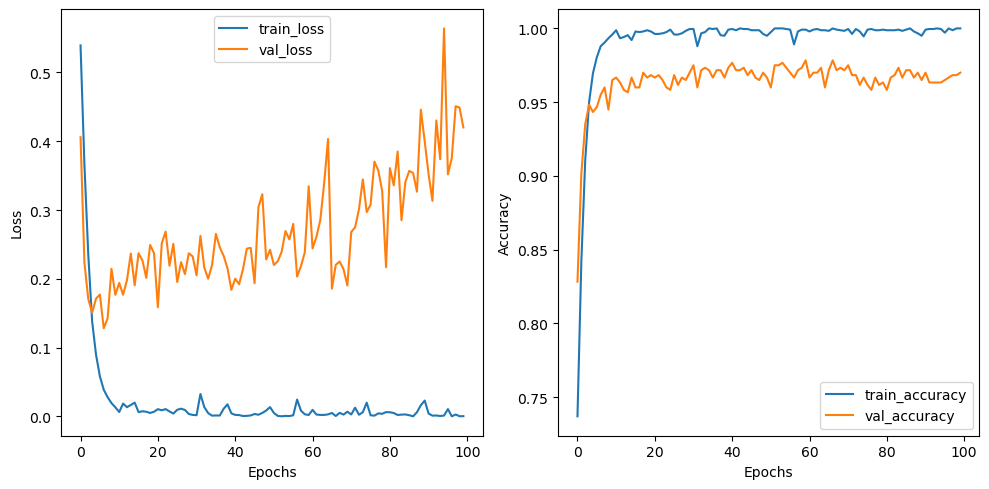

In [38]:
#Plot Results - 100 Epoch | 16 batch
plot_training_results(results100)

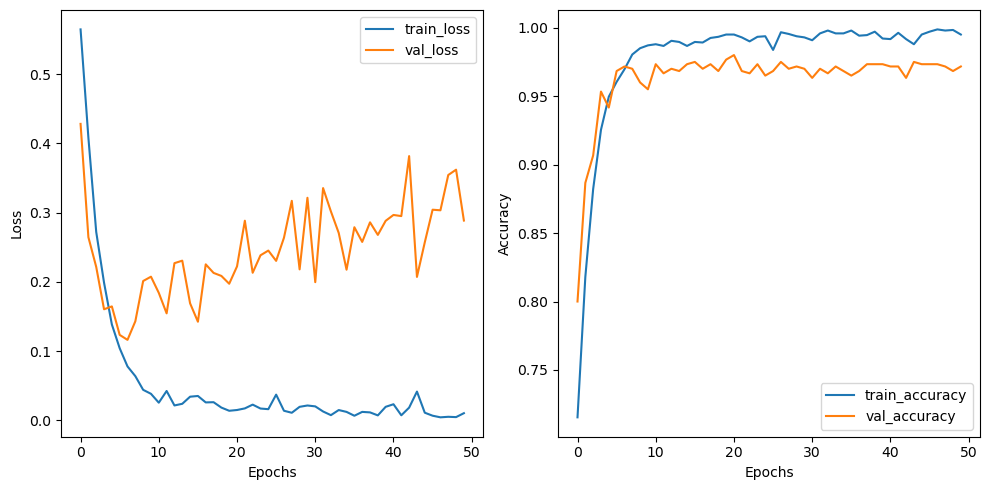

In [46]:
#Plot Results - 50 Epoch | 16 batch
plot_training_results(results50)

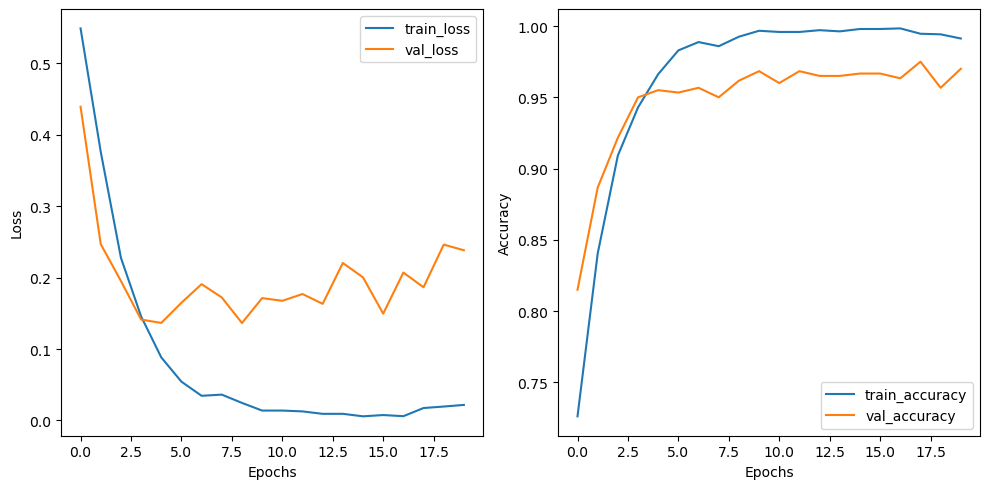

In [51]:
#Plot Results - 20 Epoch | 16 batch
plot_training_results(results20)

___

<font color = 'red'><i><u>Classification Report</u></i></font>

In [18]:
# Use the trained model to predict probabilities for the test data
y_pred_prob = model.predict(X_val)

# Convert probabilities to class labels based on a threshold
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)
# print(y_pred)

# Print the classification report
print(classification_report(y_val, y_pred, zero_division=1))

19/19 [==============================] - 4s 189ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       285
           1       0.99      0.99      0.99       315

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



___

<font color = 'red'><i><u> Model Summary</u></i></font>

In [ ]:
model.summary()

___

<b><font color = 'orange' size='4'> EVALUATION </font><b>

<b><font color = 'green'> 100 epochs </font></b><br>

<div style="text-align: justify">
According to the train loss vs the val loss, the data seems ideally going well at around 7 epochs, then converges. But before I consider the possibility of overfitting, batch size will be the first parameter to tweak as a low batch size renders less memory but takes more time, leading to better generalization.<br>
<br>
When considering the Classification Report, it seems like the model might be running perfect at 99% across the board. To account for the loss variance and volatility, regularization is an option to consider, augmenting the data, or hyperparameter tuning.<br>
    
<b><font color = 'green'> 50 epochs </font></b><br>
Running the model at 50 epochs is an amplified version of 100 epochs. Its clearly evident the model is converging as the val losses and val accuracy going into unfavorable direction at a given point. (val loss > train loss) (val accuracy < train accuracy)

<b><font color = 'green'> 20 epochs </font></b><br>
At 20 epochs, I can see the model is doing fairly well as the lines are smoothened out. It seems as if the validation data is not performing as well, which will require some adjustments to the model.
</div>

___

<b><font color = FF72FB size='4'> Improvements </font></b> <i>(To be made)</i>

<b> Code </b>
<ul>
    <li> When writing the code for the plot, classification report, and model summary, its best to combine all codes into one function so that after the model is done running, the information is properly displayed for that point in time the model ran. </li>
    <li>Making a function for the model will be considered to avoid redundency.</li>
</ul>

<b> Model </b>
<ul>
    <li> Improve model by changing the parameters</li>
    <li>Consider the possibility of overfitting</li>
    <li><i>TBD after the above was considered</i></li>
</ul>

#### <div style="text-align: center"><font color = 'red' size='5'><b>01 HYPERPARAMETER TUNING</b></font></div>

<div style="text-align: justify">
As for improvements to the model and functionality, I decided to create a cell for tuning parameters. Its made easy to adjust batch size, epoch, learning rate, and augmentation in one simple cell. This helps with consistency and easy-to-use tuning.<br><br>
For this portion of tuning, different epoch levels will be evaluated to determine what epoch should be considered moving forward so the tuning parameters wont be much of use, but will be referenced upon determination.
    </div>

<i>Tuning Paramenters</i>

In [11]:
##############(Image Size)###############
#IMG_SIZE = IMG_SIZE

#########################################




##############(Batch Size)###############
batch_size = 32

#########################################




################(Epoch)##################
epoch = 30

#########################################




###########(Exponential Decay)###########
# Learning rate schedule parameters
initial_lr = 0.001
decay_steps = 1000
decay_rate = 0.96
#########################################



############(ImageGenerator)############
# Parameters used in ImageGenerator
rotation_range=20
width_shift_range=0.2
height_shift_range=0.2
shear_range=0.2
zoom_range=0.2
horizontal_flip=True
fill_mode='nearest'
#########################################



##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 1 - ADJUST EPOCH</b></font></div>

<i>Instantiate</i>

In [20]:
#Instantiate model
model = Sequential()

<i>Compile</i>

In [17]:
model.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


# Flatten the output of the previous layer to a 1D array
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


################################################################################
################################################################################

<b><font color = 'red'> EXECUTE </font></b>

<div style="text-align: center"> <b> 100 Epoch </b> <i>at 32 batch</i> </div> 

In [14]:
# Exexcute the model
results100 = model.fit(X_train, y_train, batch_size = batch_size, 
          verbose=1, 
          epochs=100,
          validation_data= (X_val, y_val),
          shuffle = False)

# Save model
model.save('model/brain_tumor_base_100_epochs_32.h5')

Epoch 1/100
75/75 [==============================] - 24s 312ms/step - loss: 0.5028 - accuracy: 0.7600 - val_loss: 0.4058 - val_accuracy: 0.8133
Epoch 2/100
75/75 [==============================] - 24s 321ms/step - loss: 0.3495 - accuracy: 0.8500 - val_loss: 0.2646 - val_accuracy: 0.8750
Epoch 3/100
75/75 [==============================] - 25s 329ms/step - loss: 0.2511 - accuracy: 0.8954 - val_loss: 0.1911 - val_accuracy: 0.9283
Epoch 4/100
75/75 [==============================] - 24s 326ms/step - loss: 0.1611 - accuracy: 0.9425 - val_loss: 0.1397 - val_accuracy: 0.9583
Epoch 5/100
75/75 [==============================] - 25s 327ms/step - loss: 0.1056 - accuracy: 0.9633 - val_loss: 0.1233 - val_accuracy: 0.9650
Epoch 6/100
75/75 [==============================] - 24s 324ms/step - loss: 0.0669 - accuracy: 0.9779 - val_loss: 0.1460 - val_accuracy: 0.9483
Epoch 7/100
75/75 [==============================] - 24s 320ms/step - loss: 0.0563 - accuracy: 0.9833 - val_loss: 0.0878 - val_accuracy:

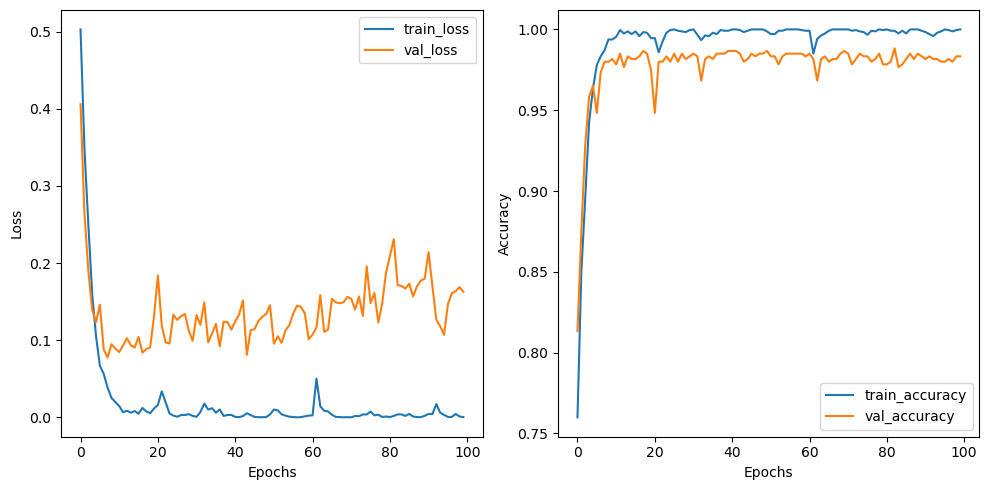

19/19 [==============================] - 1s 68ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       286
           1       0.98      0.98      0.98       314

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv

In [15]:
plot_training_results(results100)

As you can see, when adjusting the batch size, we were able to reduce the convergence gap between loss and accuracy charts. <br>

Lets try to run the model at 64 batch, and see if it will help improve closing the convergence gap.

<div style="text-align: center"> <b> 100 Epoch </b> <i>at <font color = 'red'>64</font> batch</i> </div> 

In [18]:
# Exexcute the model
results100 = model.fit(X_train, y_train, batch_size = batch_size, 
          verbose=1, 
          epochs=100,
          validation_data= (X_val, y_val),
          shuffle = False)

# Save model
model.save('model/brain_tumor_base_100_epochs_64.h5')

Epoch 1/100
75/75 [==============================] - 25s 326ms/step - loss: 0.5194 - accuracy: 0.7521 - val_loss: 0.4341 - val_accuracy: 0.8067
Epoch 2/100
75/75 [==============================] - 25s 334ms/step - loss: 0.3699 - accuracy: 0.8375 - val_loss: 0.2819 - val_accuracy: 0.8767
Epoch 3/100
75/75 [==============================] - 25s 331ms/step - loss: 0.2562 - accuracy: 0.8942 - val_loss: 0.2069 - val_accuracy: 0.9183
Epoch 4/100
75/75 [==============================] - 25s 328ms/step - loss: 0.1901 - accuracy: 0.9250 - val_loss: 0.1753 - val_accuracy: 0.9333
Epoch 5/100
75/75 [==============================] - 25s 330ms/step - loss: 0.1288 - accuracy: 0.9521 - val_loss: 0.1291 - val_accuracy: 0.9600
Epoch 6/100
75/75 [==============================] - 25s 339ms/step - loss: 0.0923 - accuracy: 0.9708 - val_loss: 0.1102 - val_accuracy: 0.9667
Epoch 7/100
75/75 [==============================] - 25s 333ms/step - loss: 0.0608 - accuracy: 0.9821 - val_loss: 0.0893 - val_accuracy:

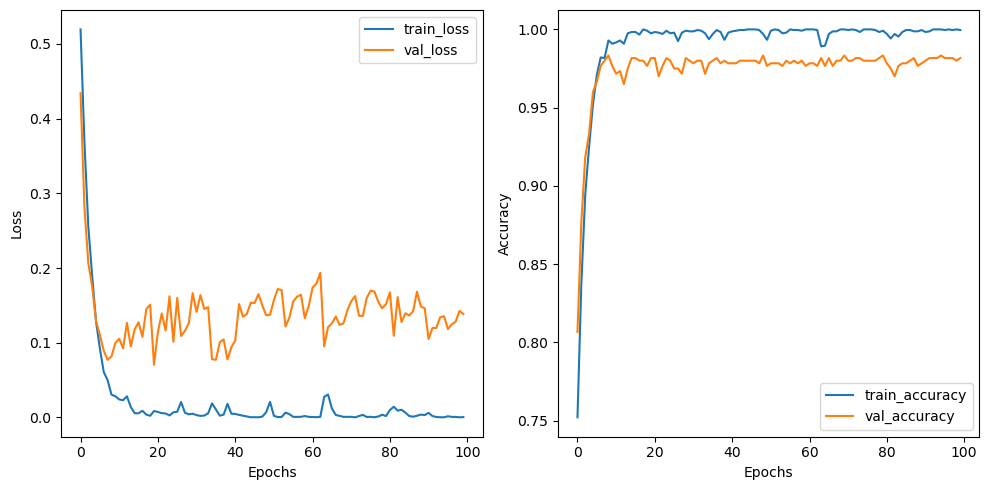

19/19 [==============================] - 1s 68ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       286
           1       0.98      0.98      0.98       314

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 co

In [19]:
plot_training_results(results100)

Making the batch 64 did help smoothen out the accuracy and loss, but made the validation accuracy and loss a bit more volatile. Next step is to regularize the model to reduce sudden jumps in validation loss and accuracy.

___

##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 2 - ADD REGULARIZATION</b></font></div>

<div style="text-align: justify">
Regularization techniques, such as L2 regularization, play a crucial role in managing the complexity of a model and enhancing its generalization capabilities by mitigating overfitting. L2 regularization achieves this by imposing a penalty on large weight values within the model. By penalizing these weights, L2 regularization encourages the model to prioritize robust and significant patterns in the data. Consequently, the model becomes less likely to rely on noise or irrelevant features, resulting in improved performance when presented with new, unseen data.
    </div>

<i>Instantiate</i>

In [21]:
#Instantiate model
model = Sequential()

<i>Compile</i>

In [27]:
model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Flatten the output of the previous layer to a 1D array
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


################################################################################
################################################################################

<i> Execute </i>

<div style="text-align: center"> <b> 100 Epoch </b> <i>at <font color = 'red'>64</font> batch</i> with <i><font color = 'green'> Regularizer </font></i> </div> 

In [28]:
# Exexcute the model
results100 = model.fit(X_train, y_train, batch_size = batch_size, 
          verbose=1, 
          epochs=100,
          validation_data= (X_val, y_val),
          shuffle = False)

# Save model
model.save('model/brain_tumor_base_100_epochs_64_reg.h5')

Epoch 1/100
75/75 [==============================] - 22s 290ms/step - loss: 0.7898 - accuracy: 0.6513 - val_loss: 0.6714 - val_accuracy: 0.7400
Epoch 2/100
75/75 [==============================] - 24s 326ms/step - loss: 0.5961 - accuracy: 0.7912 - val_loss: 0.5637 - val_accuracy: 0.7900
Epoch 3/100
75/75 [==============================] - 24s 320ms/step - loss: 0.4981 - accuracy: 0.8258 - val_loss: 0.4630 - val_accuracy: 0.8283
Epoch 4/100
75/75 [==============================] - 24s 318ms/step - loss: 0.4234 - accuracy: 0.8667 - val_loss: 0.4244 - val_accuracy: 0.8500
Epoch 5/100
75/75 [==============================] - 23s 306ms/step - loss: 0.3683 - accuracy: 0.9013 - val_loss: 0.3828 - val_accuracy: 0.8817
Epoch 6/100
75/75 [==============================] - 23s 305ms/step - loss: 0.3212 - accuracy: 0.9233 - val_loss: 0.3333 - val_accuracy: 0.9150
Epoch 7/100
75/75 [==============================] - 22s 300ms/step - loss: 0.2881 - accuracy: 0.9392 - val_loss: 0.3141 - val_accuracy:

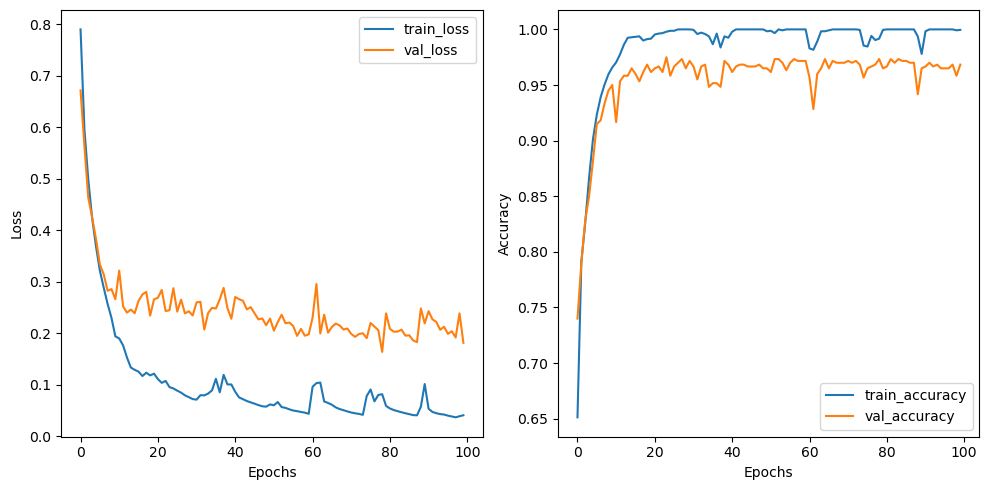

19/19 [==============================] - 1s 65ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       286
           1       0.96      0.98      0.97       314

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 activation_10 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 co

In [29]:
plot_training_results(results100)

<div style="text-align: justify">
Although the gap has closed up a bit, it made the training loss and accuracy more volatile, resulting to be ineffective. To test the waters, data augmentation will be added into the model.  This will artificially increase the data size and add more diversity to the dataset with hopes to reduce overfitting and add more generalization to close the gap and reduce volatility.
    </div>

___

##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 3 - ADD DATA AUGMENTATION</b></font></div>

<i>Instantiate</i>

In [32]:
#Instantiate model
model = Sequential()

<i>Compile</i>

In [33]:
# Create an instance of the ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=rotation_range,  # Randomly rotate images by 10 degrees
    width_shift_range=width_shift_range,  # Randomly shift images horizontally by 10% of the total width
    height_shift_range=height_shift_range,  # Randomly shift images vertically by 10% of the total height
    zoom_range=zoom_range,  # Randomly zoom images by 10%
    horizontal_flip=horizontal_flip  # Randomly flip images horizontally
)

# Apply data augmentation to the training data generator
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

# Define and compile your model
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


<div style="text-align: center"> <b> 100 Epoch </b> <i>at <font color = 'red'>64</font> batch</i> with <i><font color = 'blue'> Augmentation </font></i> </div> 

In [34]:
# Exexcute the model
# Train the model using the augmented data generator
results100_augmented = model.fit(train_generator, epochs=100, validation_data=(X_val, y_val))

# Save model
model.save('model/brain_tumor_base_100_epochs_64_aug.h5')

Epoch 1/100
75/75 [==============================] - 26s 332ms/step - loss: 0.6929 - accuracy: 0.5433 - val_loss: 0.6699 - val_accuracy: 0.6150
Epoch 2/100
75/75 [==============================] - 26s 347ms/step - loss: 0.6570 - accuracy: 0.6154 - val_loss: 0.6131 - val_accuracy: 0.6783
Epoch 3/100
75/75 [==============================] - 27s 359ms/step - loss: 0.6354 - accuracy: 0.6417 - val_loss: 0.5528 - val_accuracy: 0.7067
Epoch 4/100
75/75 [==============================] - 28s 375ms/step - loss: 0.6181 - accuracy: 0.6775 - val_loss: 0.6385 - val_accuracy: 0.6633
Epoch 5/100
75/75 [==============================] - 27s 361ms/step - loss: 0.6066 - accuracy: 0.6888 - val_loss: 0.5271 - val_accuracy: 0.7600
Epoch 6/100
75/75 [==============================] - 27s 361ms/step - loss: 0.5804 - accuracy: 0.7000 - val_loss: 0.5117 - val_accuracy: 0.7650
Epoch 7/100
75/75 [==============================] - 27s 355ms/step - loss: 0.5825 - accuracy: 0.6967 - val_loss: 0.4879 - val_accuracy:

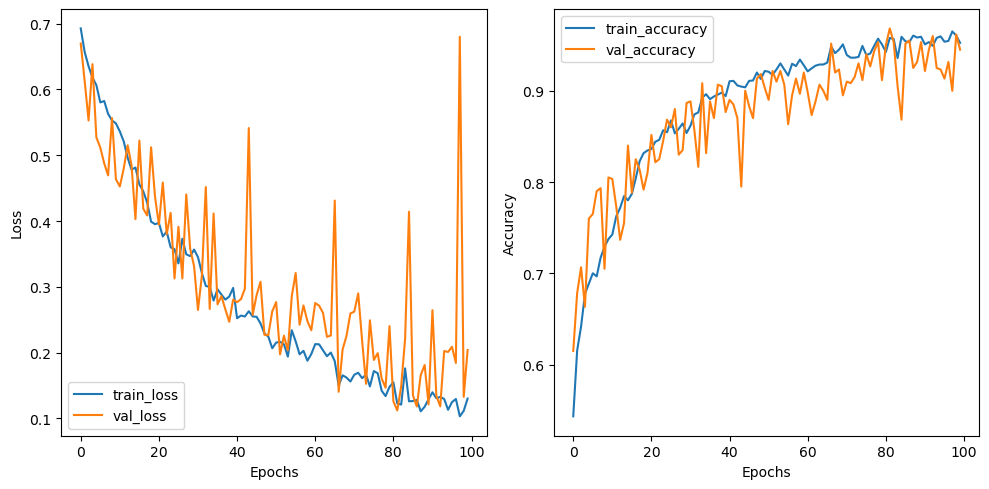

19/19 [==============================] - 2s 77ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       286
           1       0.96      0.93      0.95       314

    accuracy                           0.94       600
   macro avg       0.94      0.95      0.94       600
weighted avg       0.95      0.94      0.95       600

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_20 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 co

In [35]:
plot_training_results(results100_augmented)

Adding the augmentation and removing the regularizer made matters worse. The model will be ran with both augmentation and regularizer to see if they tend to balance out.

##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 4 - DATA AUGMENTATION</b></font> <b>with <i>Regularization</i></b></div>

<i>Instantiate</i>

In [36]:
#Instantiate model
model = Sequential()

<i>Compile</i>

In [37]:
# Create an instance of the ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=rotation_range,  # Randomly rotate images by 10 degrees
    width_shift_range=width_shift_range,  # Randomly shift images horizontally by 10% of the total width
    height_shift_range=height_shift_range,  # Randomly shift images vertically by 10% of the total height
    zoom_range=zoom_range,  # Randomly zoom images by 10%
    horizontal_flip=horizontal_flip  # Randomly flip images horizontally
)

# Apply data augmentation to the training data generator
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

# Define and compile your model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


<div style="text-align: center"> <b> 100 Epoch </b> <i>at <font color = 'red'>64</font> batch</i> with <i><font color = 'blue'> Augmentation </font></i> and <font color='green'><i>Regularization</i></font> </div> 

In [38]:
# Exexcute the model
# Train the model using the augmented data generator
results100_augmented = model.fit(train_generator, epochs=100, validation_data=(X_val, y_val))

# Save model
model.save('model/brain_tumor_base_100_epochs_64_aug_reg.h5')

Epoch 1/100
75/75 [==============================] - 27s 348ms/step - loss: 0.6755 - accuracy: 0.5904 - val_loss: 0.6600 - val_accuracy: 0.5817
Epoch 2/100
75/75 [==============================] - 29s 385ms/step - loss: 0.6435 - accuracy: 0.6258 - val_loss: 0.6009 - val_accuracy: 0.7133
Epoch 3/100
75/75 [==============================] - 29s 384ms/step - loss: 0.6099 - accuracy: 0.6808 - val_loss: 0.5362 - val_accuracy: 0.7450
Epoch 4/100
75/75 [==============================] - 29s 383ms/step - loss: 0.5985 - accuracy: 0.7021 - val_loss: 0.5585 - val_accuracy: 0.7283
Epoch 5/100
75/75 [==============================] - 27s 363ms/step - loss: 0.5922 - accuracy: 0.6892 - val_loss: 0.5145 - val_accuracy: 0.7717
Epoch 6/100
75/75 [==============================] - 31s 406ms/step - loss: 0.5857 - accuracy: 0.6967 - val_loss: 0.5027 - val_accuracy: 0.7817
Epoch 7/100
75/75 [==============================] - 30s 394ms/step - loss: 0.5537 - accuracy: 0.7346 - val_loss: 0.5086 - val_accuracy:

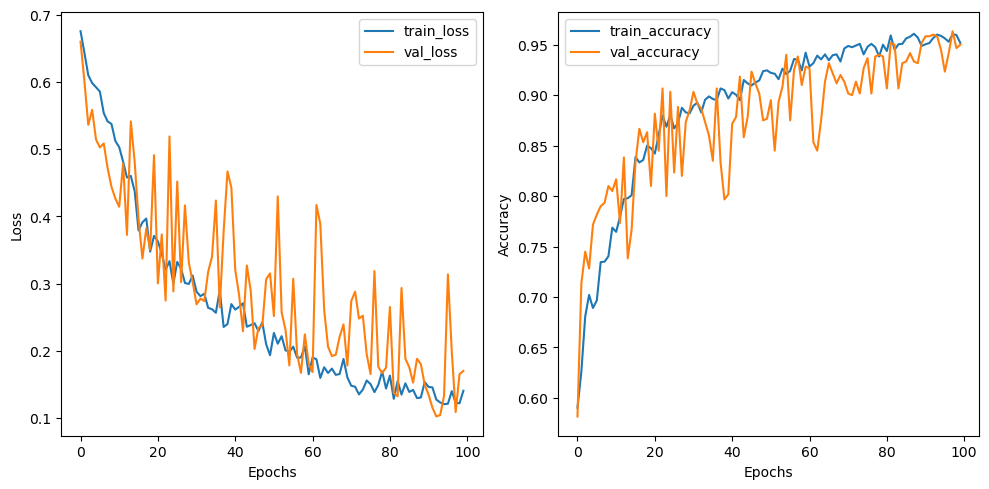

19/19 [==============================] - 2s 83ms/step
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       286
           1       0.96      0.95      0.95       314

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_25 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 co

In [39]:
plot_training_results(results100_augmented)

In [41]:
test_loss, test_acc = model.evaluate(X_val, y_val)
model_acc_loss(test_acc, test_loss)

19/19 [==============================] - 1s 75ms/step - loss: 0.1702 - accuracy: 0.9500
Model Accuracy (Test data)
________________________________________

Model Accuracy:       0.949999988079071
Test Loss:           0.1702447086572647
________________________________________



Adding the Regularizer and the data augmentation parameters didnt really help much but it tended to create more spikes. To combat this, a learning scheduler will be applied to see if it can reduce the learning rate, and help reduce volatility.

___

##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 5 - ADD LEARNING RATE SCHEDULER</b></font> <b>with <i>Regularization & Augmentation</i></b></div>

<i>Instantiate</i>

In [50]:
#Instantiate model
model = Sequential()

<i>Compile</i>

In [45]:
from keras.callbacks import ReduceLROnPlateau

# Create an instance of the ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=rotation_range,  # Randomly rotate images by 10 degrees
    width_shift_range=width_shift_range,  # Randomly shift images horizontally by 10% of the total width
    height_shift_range=height_shift_range,  # Randomly shift images vertically by 10% of the total height
    zoom_range=zoom_range,  # Randomly zoom images by 10%
    horizontal_flip=horizontal_flip  # Randomly flip images horizontally
)

# Apply data augmentation to the training data generator
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

# Define and compile your model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)




<div style="text-align: center"> <b> 100 Epoch (LR_Scheduler)</b> <i>at <font color = 'red'>64</font> batch</i> with <i><font color = 'blue'> Augmentation </font></i> and <font color='green'><i>Regularization</i></font> </div> 

In [49]:
# Exexcute the model
# Train the model with the learning rate scheduler
results100_ver5 = model.fit(train_generator, epochs=100, validation_data=(X_val, y_val), callbacks=[lr_scheduler])

# Save model
model.save('model/brain_tumor_base_100_epochs_64_aug_reg_LR_sched.h5')

Epoch 1/100
75/75 [==============================] - 26s 349ms/step - loss: 0.2519 - accuracy: 0.9038 - val_loss: 0.2539 - val_accuracy: 0.8950 - lr: 1.0000e-04
Epoch 2/100
75/75 [==============================] - 27s 364ms/step - loss: 0.2544 - accuracy: 0.9042 - val_loss: 0.2280 - val_accuracy: 0.9117 - lr: 1.0000e-04
Epoch 3/100
75/75 [==============================] - 27s 356ms/step - loss: 0.2565 - accuracy: 0.9050 - val_loss: 0.2220 - val_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 4/100
75/75 [==============================] - 27s 362ms/step - loss: 0.2444 - accuracy: 0.9142 - val_loss: 0.2224 - val_accuracy: 0.9167 - lr: 1.0000e-04
Epoch 5/100
75/75 [==============================] - 27s 358ms/step - loss: 0.2417 - accuracy: 0.9108 - val_loss: 0.2263 - val_accuracy: 0.9267 - lr: 1.0000e-04
Epoch 6/100
75/75 [==============================] - 27s 363ms/step - loss: 0.2446 - accuracy: 0.9125 - val_loss: 0.2196 - val_accuracy: 0.9233 - lr: 1.0000e-04
Epoch 7/100
75/75 [===============

75/75 [==============================] - 27s 363ms/step - loss: 0.2358 - accuracy: 0.9175 - val_loss: 0.2237 - val_accuracy: 0.9183 - lr: 1.0000e-10
Epoch 46/100
75/75 [==============================] - 27s 362ms/step - loss: 0.2279 - accuracy: 0.9162 - val_loss: 0.2237 - val_accuracy: 0.9183 - lr: 1.0000e-11
Epoch 47/100
75/75 [==============================] - 27s 364ms/step - loss: 0.2441 - accuracy: 0.9092 - val_loss: 0.2237 - val_accuracy: 0.9183 - lr: 1.0000e-11
Epoch 48/100
75/75 [==============================] - 27s 359ms/step - loss: 0.2385 - accuracy: 0.9129 - val_loss: 0.2237 - val_accuracy: 0.9183 - lr: 1.0000e-11
Epoch 49/100
75/75 [==============================] - 27s 361ms/step - loss: 0.2306 - accuracy: 0.9142 - val_loss: 0.2237 - val_accuracy: 0.9183 - lr: 1.0000e-11
Epoch 50/100
75/75 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9142
Epoch 50: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
75/75 [=======================

Epoch 88/100
75/75 [==============================] - 34s 455ms/step - loss: 0.2321 - accuracy: 0.9192 - val_loss: 0.2237 - val_accuracy: 0.9183 - lr: 1.0000e-19
Epoch 89/100
75/75 [==============================] - 28s 373ms/step - loss: 0.2280 - accuracy: 0.9233 - val_loss: 0.2237 - val_accuracy: 0.9183 - lr: 1.0000e-19
Epoch 90/100
75/75 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9179
Epoch 90: ReduceLROnPlateau reducing learning rate to 1.000000032889008e-20.
75/75 [==============================] - 28s 368ms/step - loss: 0.2354 - accuracy: 0.9179 - val_loss: 0.2237 - val_accuracy: 0.9183 - lr: 1.0000e-19
Epoch 91/100
75/75 [==============================] - 28s 369ms/step - loss: 0.2265 - accuracy: 0.9187 - val_loss: 0.2237 - val_accuracy: 0.9183 - lr: 1.0000e-20
Epoch 92/100
75/75 [==============================] - 27s 365ms/step - loss: 0.2332 - accuracy: 0.9129 - val_loss: 0.2237 - val_accuracy: 0.9183 - lr: 1.0000e-20
Epoch 93/100
75/75 [==========

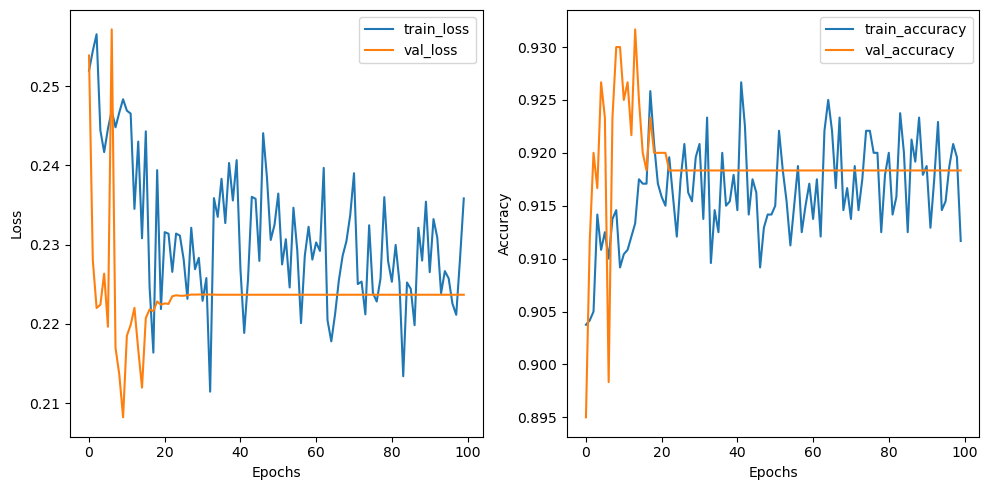

19/19 [==============================] - 0s 1ms/step


ValueError: Classification metrics can't handle a mix of binary and unknown targets

In [51]:
plot_training_results(results100_ver5)

In [41]:
test_loss, test_acc = model.evaluate(X_val, y_val)
model_acc_loss(test_acc, test_loss)

19/19 [==============================] - 1s 75ms/step - loss: 0.1702 - accuracy: 0.9500
Model Accuracy (Test data)
________________________________________

Model Accuracy:       0.949999988079071
Test Loss:           0.1702447086572647
________________________________________



##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 6 - LAYER REDUCTION</b></font> <b>back to the basics</i></b></div>

<i>Instantiate</i>

In [49]:
#Instantiate model
model = Sequential()

<i>Compile</i>

In [50]:

# Define and compile your model
model.add(Conv2D(64, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


<div style="text-align: center"> <b> 100 Epoch (LR_Scheduler)</b> <i>at <font color = 'red'>64</font> batch</i> with <i><font color = 'blue'> Augmentation </font></i> and <font color='green'><i>Regularization</i></font> </div> 

In [51]:
# Exexcute the model
results100_2 = model.fit(X_train, y_train, batch_size = 64, verbose=1, epochs=30,
                       validation_data= (X_val, y_val))
# Save model
model.save('model/brain_tumor_base_50_epochs_64_basics.h5')

Epoch 1/30
38/38 [==============================] - 50s 1s/step - loss: 0.5810 - accuracy: 0.7025 - val_loss: 0.5186 - val_accuracy: 0.7267
Epoch 2/30
38/38 [==============================] - 50s 1s/step - loss: 0.4940 - accuracy: 0.7588 - val_loss: 0.4743 - val_accuracy: 0.7683
Epoch 3/30
38/38 [==============================] - 50s 1s/step - loss: 0.4119 - accuracy: 0.8142 - val_loss: 0.4042 - val_accuracy: 0.8333
Epoch 4/30
38/38 [==============================] - 50s 1s/step - loss: 0.3490 - accuracy: 0.8529 - val_loss: 0.3226 - val_accuracy: 0.8650
Epoch 5/30
38/38 [==============================] - 52s 1s/step - loss: 0.2755 - accuracy: 0.8875 - val_loss: 0.2591 - val_accuracy: 0.9033
Epoch 6/30
38/38 [==============================] - 51s 1s/step - loss: 0.2305 - accuracy: 0.9133 - val_loss: 0.2494 - val_accuracy: 0.9133
Epoch 7/30
38/38 [==============================] - 54s 1s/step - loss: 0.1684 - accuracy: 0.9442 - val_loss: 0.1954 - val_accuracy: 0.9200
Epoch 8/30
38/38 [==

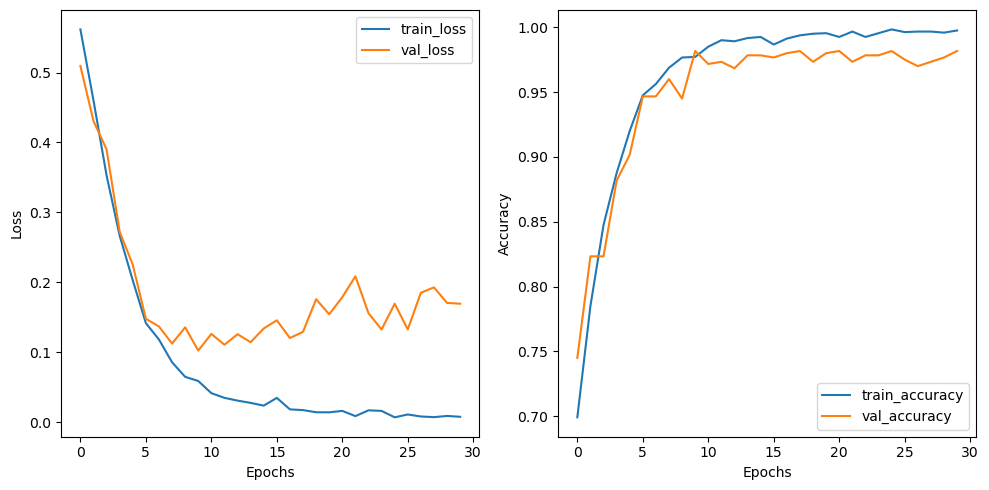

19/19 [==============================] - 5s 253ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       307
           1       0.98      0.98      0.98       293

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 128)     3584      
                                                                 
 activation_19 (Activation)  (None, 126, 126, 128)     0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 128)      0         
 2D)                                                             
                                                                 
 c

In [45]:
plot_training_results(results100_2)

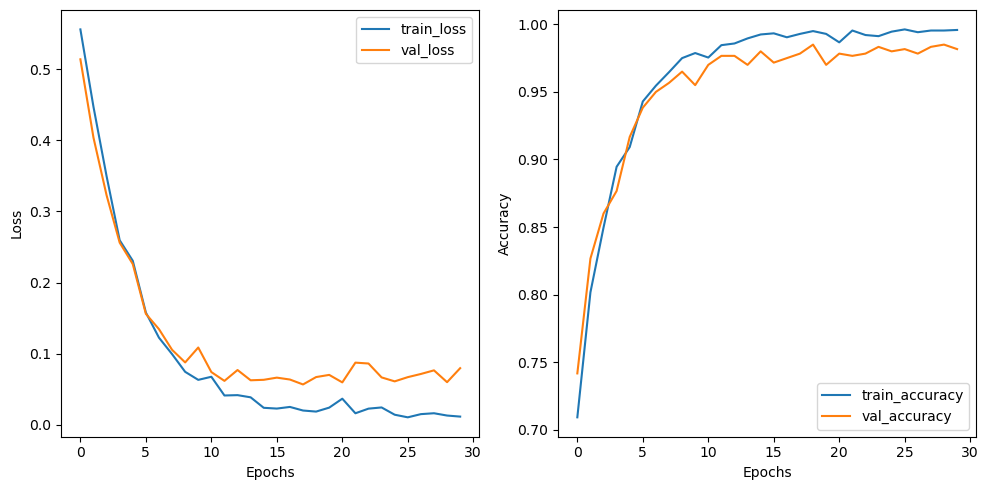

19/19 [==============================] - 3s 160ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       307
           1       0.99      0.98      0.98       293

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 activation_15 (Activation)  (None, 126, 126, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 c

In [41]:
plot_training_results(results100_2)

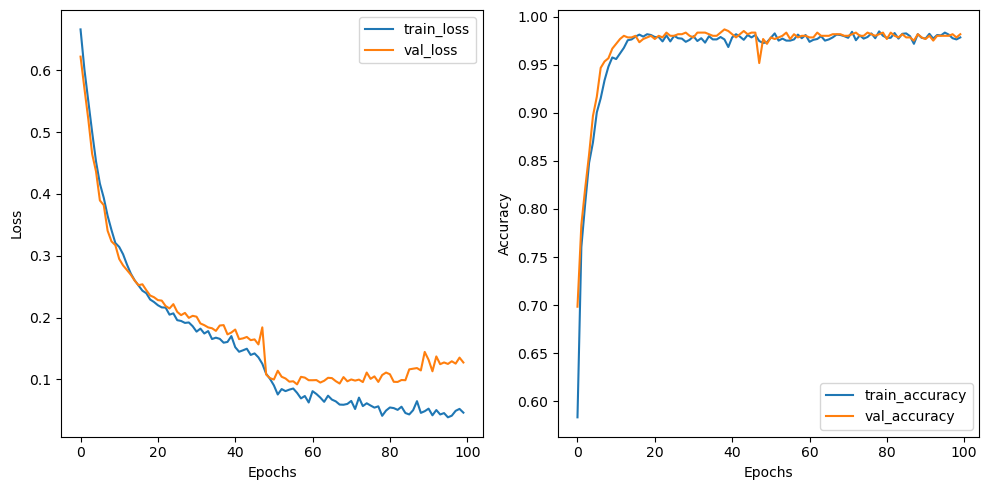

19/19 [==============================] - 1s 53ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       286
           1       0.98      0.98      0.98       314

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_55 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 f

In [92]:
plot_training_results(results100)

In [93]:
test_loss, test_acc = model.evaluate(X_val, y_val)
model_acc_loss(test_acc, test_loss)

19/19 [==============================] - 1s 45ms/step - loss: 0.1273 - accuracy: 0.9817
Model Accuracy (Test data)
________________________________________

Model Accuracy:       0.9816666841506958
Test Loss:           0.12730015814304352
________________________________________



<div style="text-align: justify">

From the previous attempts to tune the model (adding more layers, augmentation, regularization) it all makes sense to do with a complex model, but since this model is simple, it wouldnt make sense to start at a high point, but start with less features to have a better understanding of why the loss is occuring. 

Having too much hyperparameters can make a simple model look complex. As we can see, with the reduction of layers and parameters, the model able to get closer to a more uniformed model that can properly train the model.

Although its still not perfect, adding the necessary parameters to the model can fix the divergence happening in this version.
    </div>

##### <div style="text-align: left"><font color = 'purple' size='5'><b>Ver 7 - SIMPLE MODEL </b></font>  <i>no Dropout</i></div>

<i>Instantiate</i>

In [94]:
#Instantiate model
model = Sequential()

<i>Compile</i>

In [95]:

# Define and compile your model
model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(16, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


<div style="text-align: center"> <b> 100 Epoch </b><i>(No Dropout)</i></div> 

In [96]:
# Exexcute the model
results100 = model.fit(X_train, y_train, batch_size = 64, verbose=1, epochs=100,
                       validation_data= (X_val, y_val))
# Save model
model.save('model/brain_tumor_base_100_epochs_64_basics.h5')

Epoch 1/100
38/38 [==============================] - 12s 314ms/step - loss: 0.5479 - accuracy: 0.7242 - val_loss: 0.4647 - val_accuracy: 0.7667
Epoch 2/100
38/38 [==============================] - 12s 325ms/step - loss: 0.3523 - accuracy: 0.8508 - val_loss: 0.3296 - val_accuracy: 0.8750
Epoch 3/100
38/38 [==============================] - 13s 334ms/step - loss: 0.2440 - accuracy: 0.9079 - val_loss: 0.2676 - val_accuracy: 0.8983
Epoch 4/100
38/38 [==============================] - 13s 340ms/step - loss: 0.1645 - accuracy: 0.9575 - val_loss: 0.1918 - val_accuracy: 0.9317
Epoch 5/100
38/38 [==============================] - 13s 342ms/step - loss: 0.1201 - accuracy: 0.9721 - val_loss: 0.1711 - val_accuracy: 0.9350
Epoch 6/100
38/38 [==============================] - 13s 334ms/step - loss: 0.0880 - accuracy: 0.9808 - val_loss: 0.1451 - val_accuracy: 0.9600
Epoch 7/100
38/38 [==============================] - 13s 333ms/step - loss: 0.0622 - accuracy: 0.9875 - val_loss: 0.1724 - val_accuracy:

Epoch 57/100
38/38 [==============================] - 13s 349ms/step - loss: 1.9427e-04 - accuracy: 1.0000 - val_loss: 0.1230 - val_accuracy: 0.9783
Epoch 58/100
38/38 [==============================] - 13s 348ms/step - loss: 1.8940e-04 - accuracy: 1.0000 - val_loss: 0.1197 - val_accuracy: 0.9783
Epoch 59/100
38/38 [==============================] - 13s 343ms/step - loss: 1.8088e-04 - accuracy: 1.0000 - val_loss: 0.1230 - val_accuracy: 0.9783
Epoch 60/100
38/38 [==============================] - 13s 345ms/step - loss: 1.7173e-04 - accuracy: 1.0000 - val_loss: 0.1212 - val_accuracy: 0.9800
Epoch 61/100
38/38 [==============================] - 13s 343ms/step - loss: 1.7180e-04 - accuracy: 1.0000 - val_loss: 0.1227 - val_accuracy: 0.9800
Epoch 62/100
38/38 [==============================] - 13s 342ms/step - loss: 1.6147e-04 - accuracy: 1.0000 - val_loss: 0.1194 - val_accuracy: 0.9783
Epoch 63/100
38/38 [==============================] - 13s 339ms/step - loss: 1.5179e-04 - accuracy: 1.0000

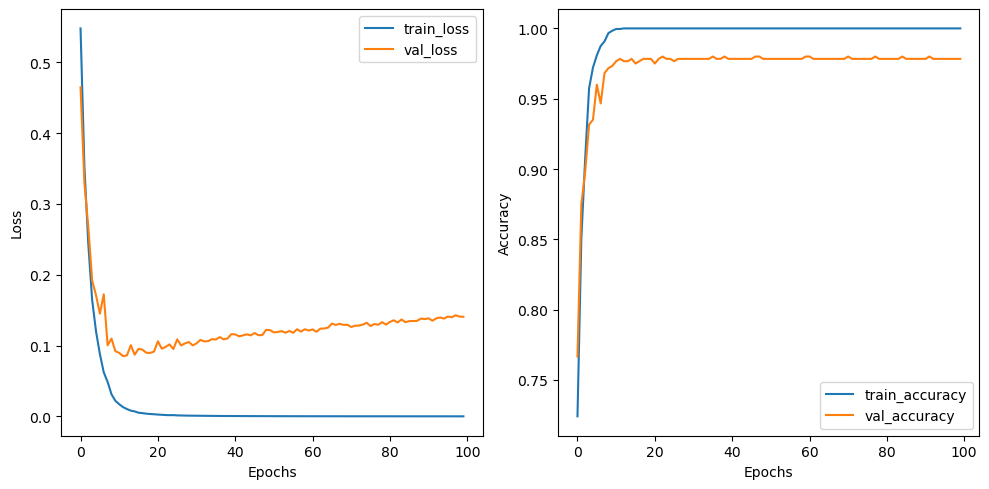

19/19 [==============================] - 1s 46ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       286
           1       0.99      0.97      0.98       314

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_57 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 f

In [97]:
plot_training_results(results100)

In [93]:
test_loss, test_acc = model.evaluate(X_val, y_val)
model_acc_loss(test_acc, test_loss)

19/19 [==============================] - 1s 45ms/step - loss: 0.1273 - accuracy: 0.9817
Model Accuracy (Test data)
________________________________________

Model Accuracy:       0.9816666841506958
Test Loss:           0.12730015814304352
________________________________________



Epoch 1/30
75/75 [==============================] - 58s 764ms/step - loss: 0.7860 - accuracy: 0.5550 - val_loss: 0.7290 - val_accuracy: 0.5033
Epoch 2/30
75/75 [==============================] - 57s 752ms/step - loss: 0.7187 - accuracy: 0.5067 - val_loss: 0.7103 - val_accuracy: 0.5083
Epoch 3/30
75/75 [==============================] - 61s 816ms/step - loss: 0.7064 - accuracy: 0.5142 - val_loss: 0.6996 - val_accuracy: 0.6133
Epoch 4/30
75/75 [==============================] - 58s 775ms/step - loss: 0.6940 - accuracy: 0.5517 - val_loss: 0.6878 - val_accuracy: 0.5467
Epoch 5/30
75/75 [==============================] - 58s 779ms/step - loss: 0.6647 - accuracy: 0.6313 - val_loss: 0.6893 - val_accuracy: 0.5400
Epoch 6/30
75/75 [==============================] - 58s 765ms/step - loss: 0.6659 - accuracy: 0.6142 - val_loss: 0.6644 - val_accuracy: 0.5883
Epoch 7/30
75/75 [==============================] - 58s 770ms/step - loss: 0.6527 - accuracy: 0.6450 - val_loss: 0.6298 - val_accuracy: 0.6550

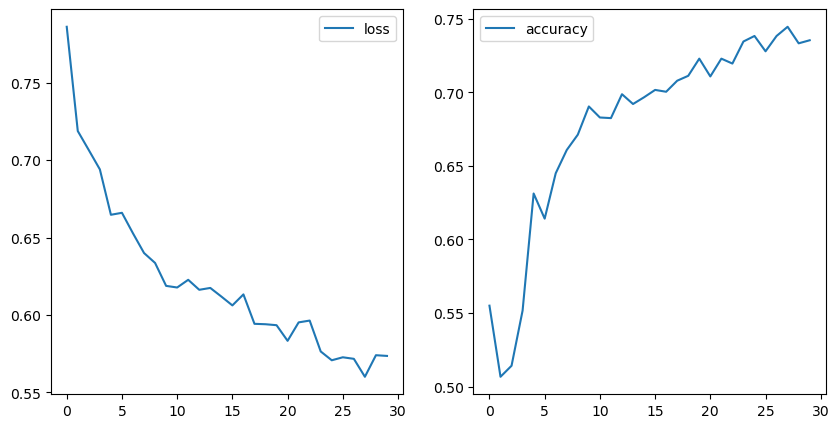

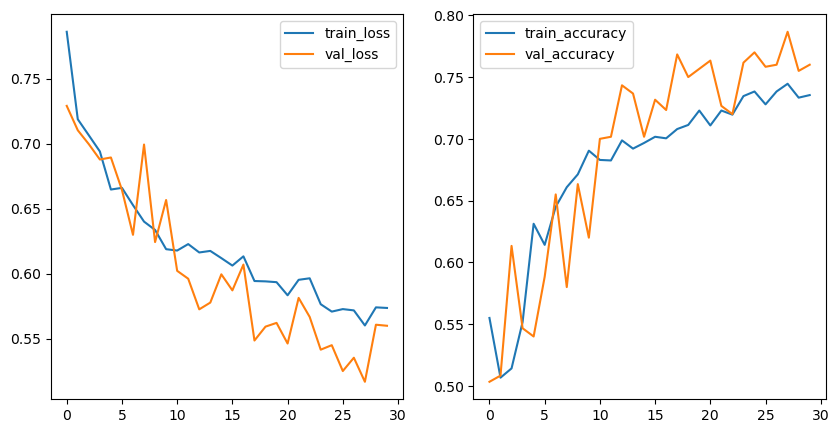

In [100]:
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(Conv2D(64, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation('sigmoid'))



# LEARNING RATE SCHEDULE (ExponentialDecay)
# MODIFICATIONS CAN BE MADE IN THE TUNING PARAMETERS SECTION ABOVE
learning_rate = ExponentialDecay(initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate)
optimizer = Adam(learning_rate=learning_rate)


# AUGMENTATION (ImageDataGenerator)
# MODIFICATIONS CAN BE MADE IN THE TUNING PARAMETERS SECTION ABOVE
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    fill_mode=fill_mode
)

# Compile
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Run model (Augmented version)
results_augmented = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                              validation_data=(X_val, y_val),
                              verbose=1,
                              shuffle=False,
                              epochs=epoch)

# Save model (Augmented version)
model.save('brain_tumor_30_epochs_augmented_v13.h5')


sigmoid_loss = results_augmented.history['loss']
sigmoid_accuracy = results_augmented.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results_augmented.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results_augmented.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

train_loss = results_augmented.history['loss']
train_acc = results_augmented.history['accuracy']
val_loss = results_augmented.history['val_loss']
val_acc = results_augmented.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results_augmented.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results_augmented.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results_augmented.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results_augmented.epoch, y=val_acc, ax=ax2, label='val_accuracy');